## Exploratory Data Analysis (EDA) for Fraud Detection

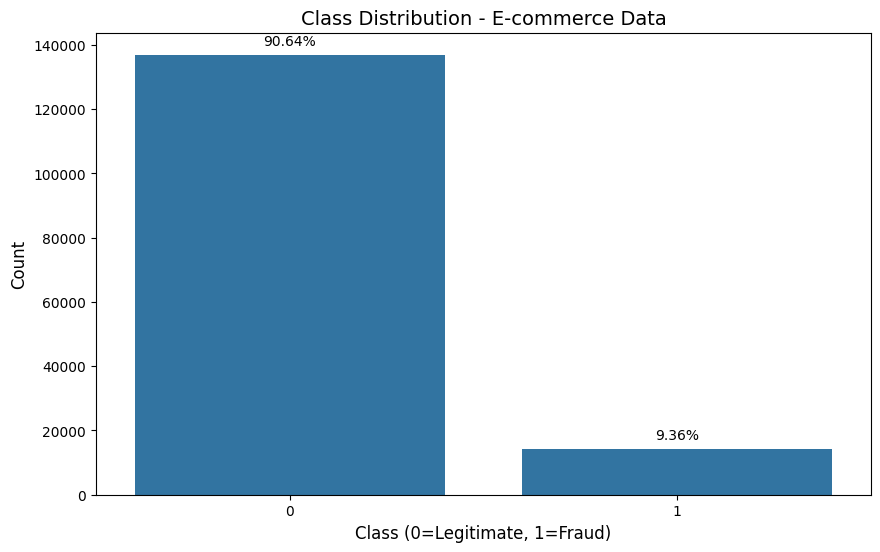

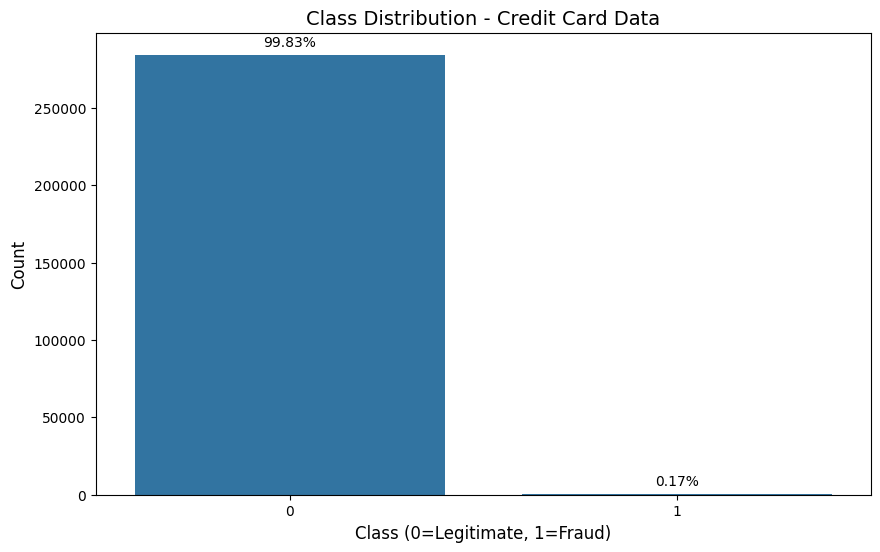

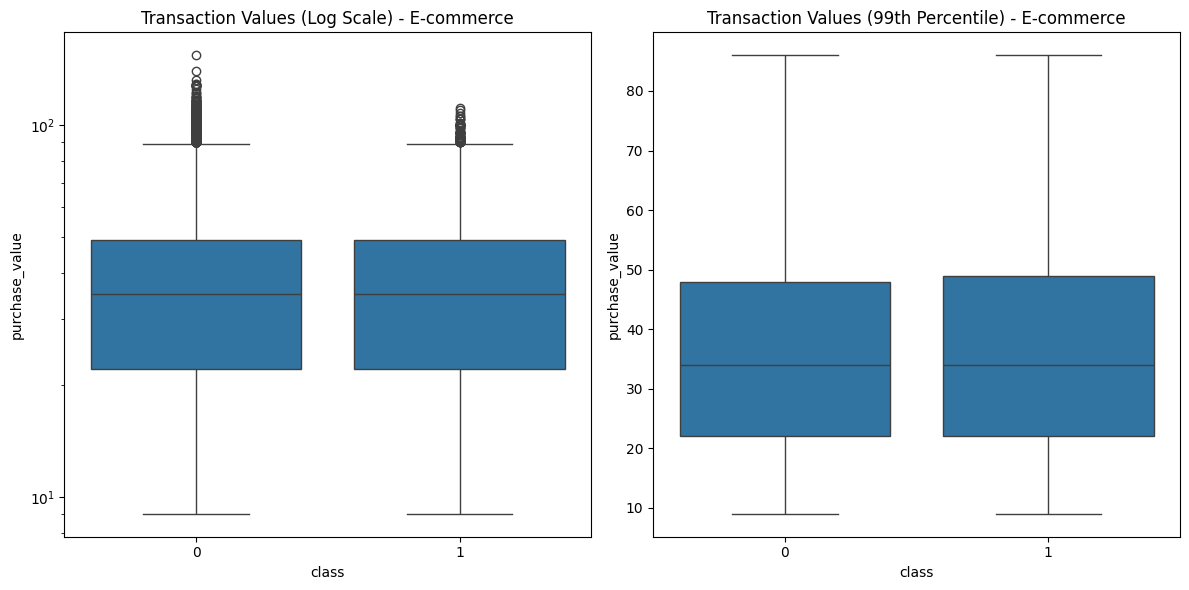

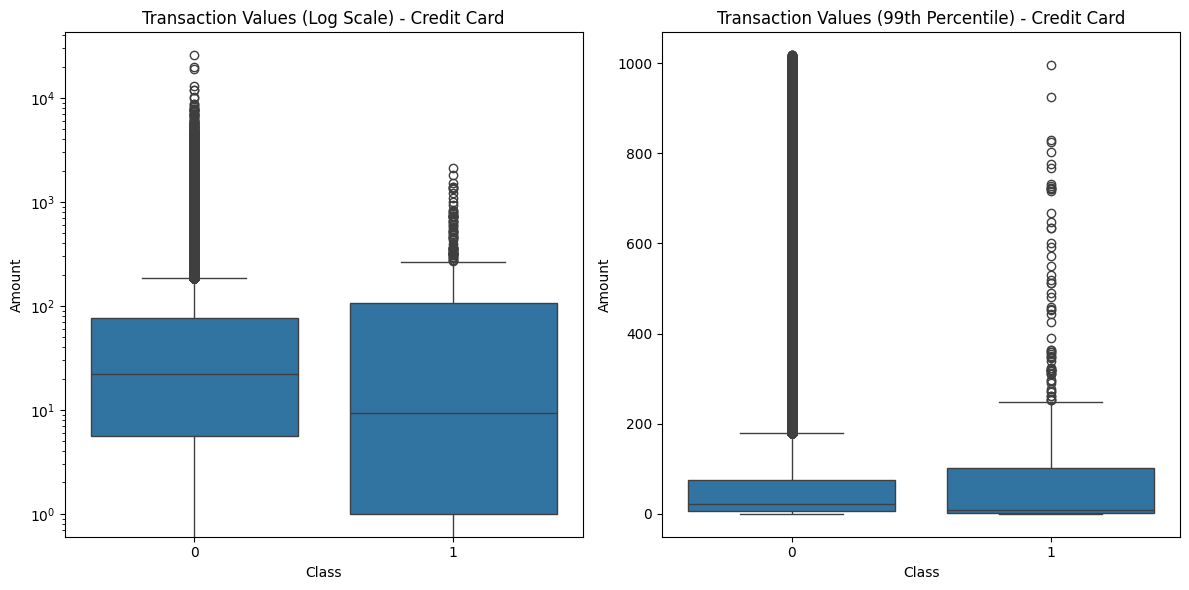

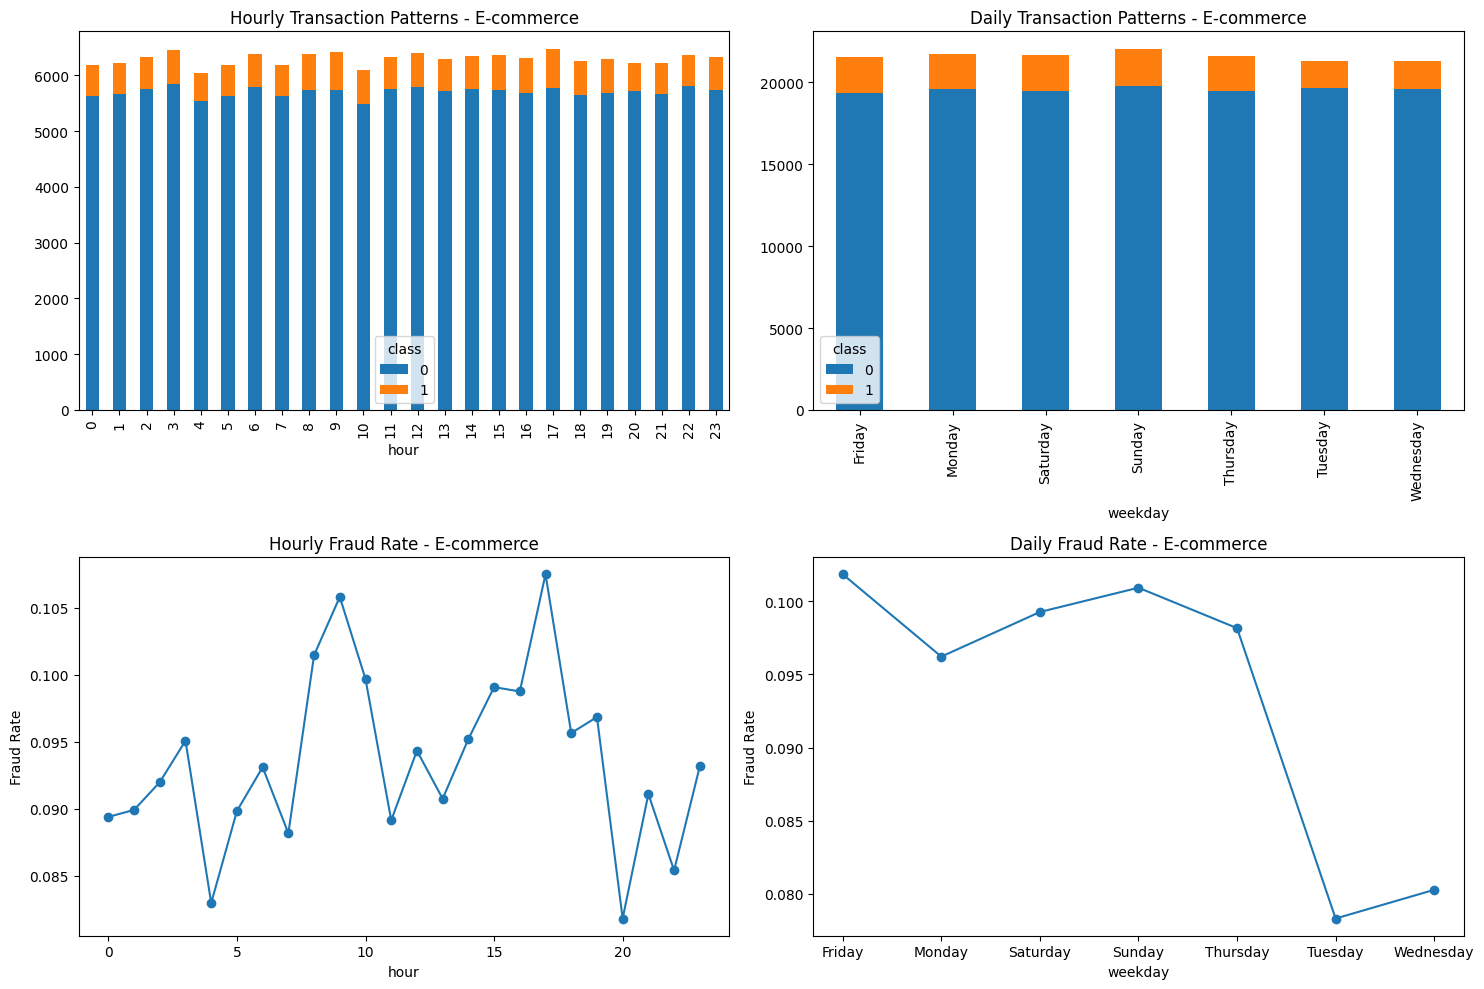

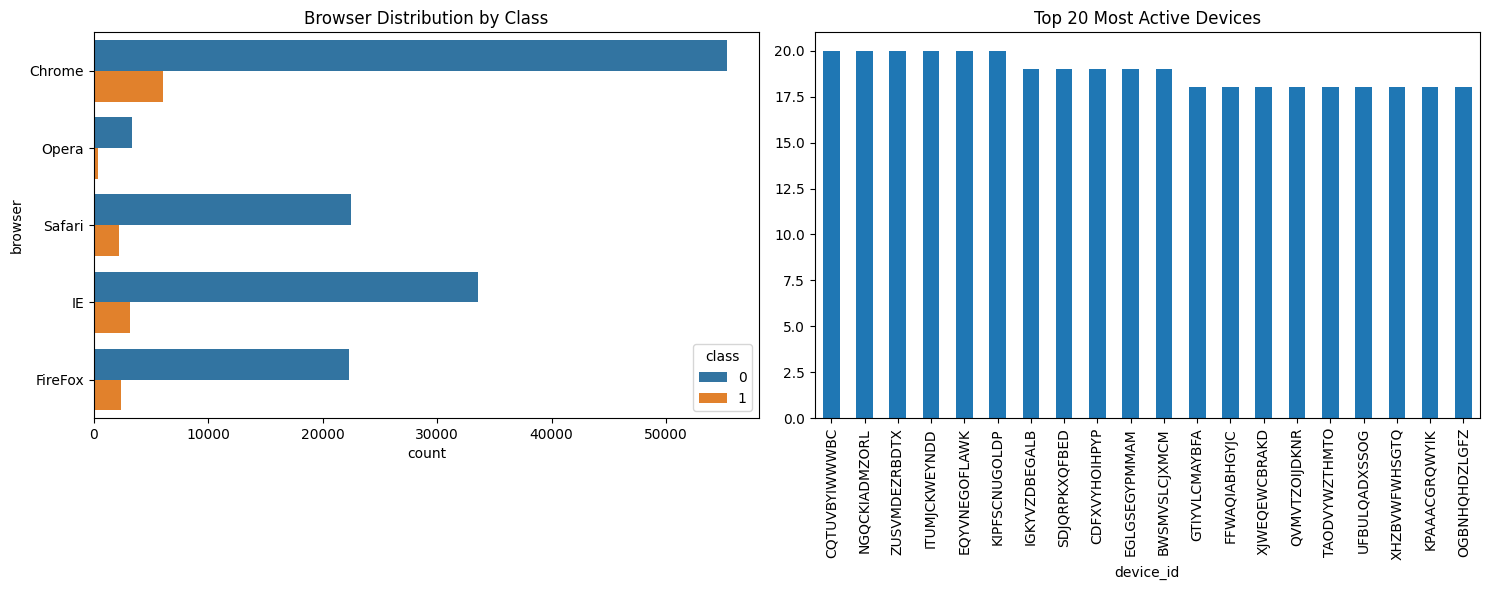

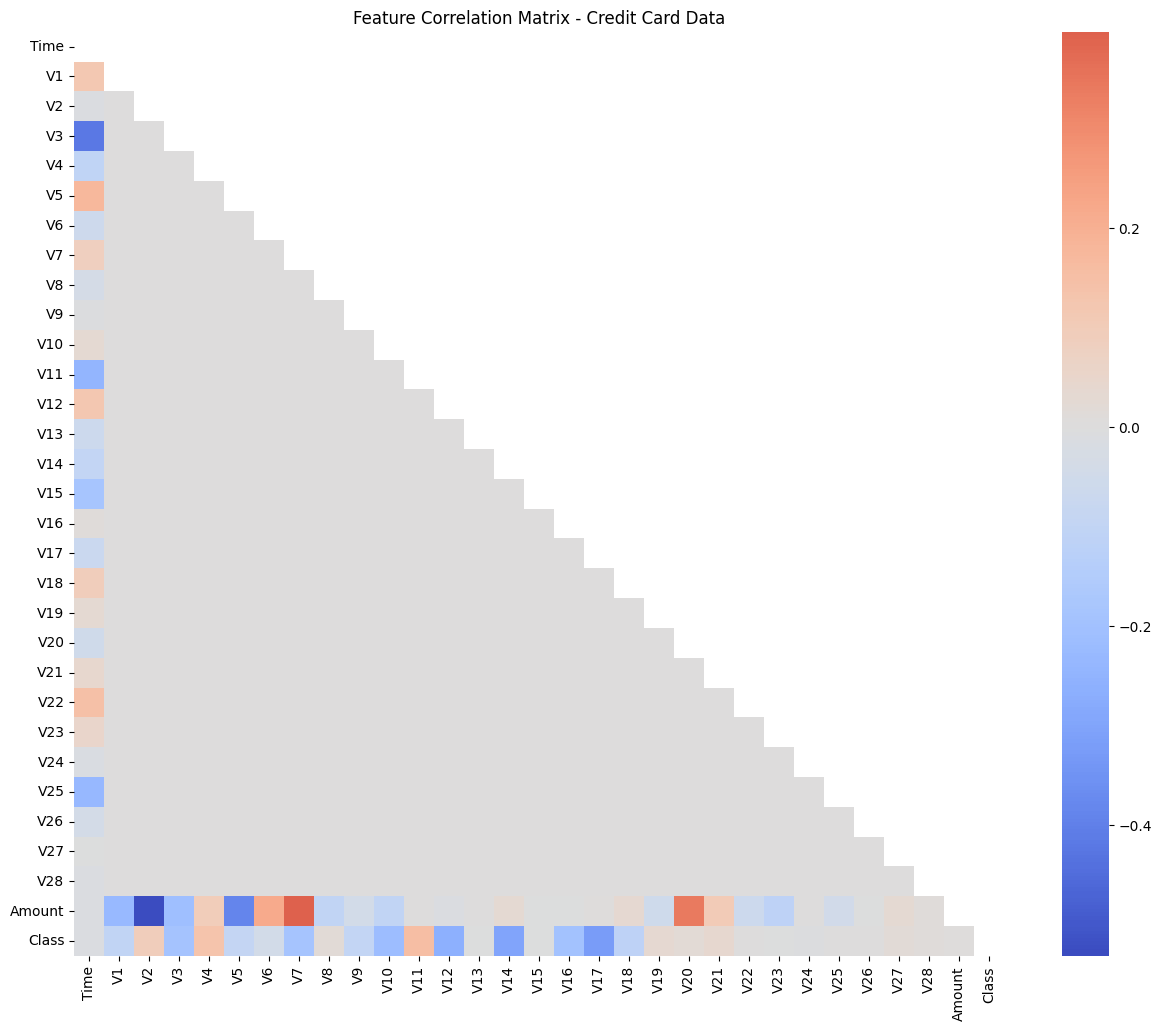

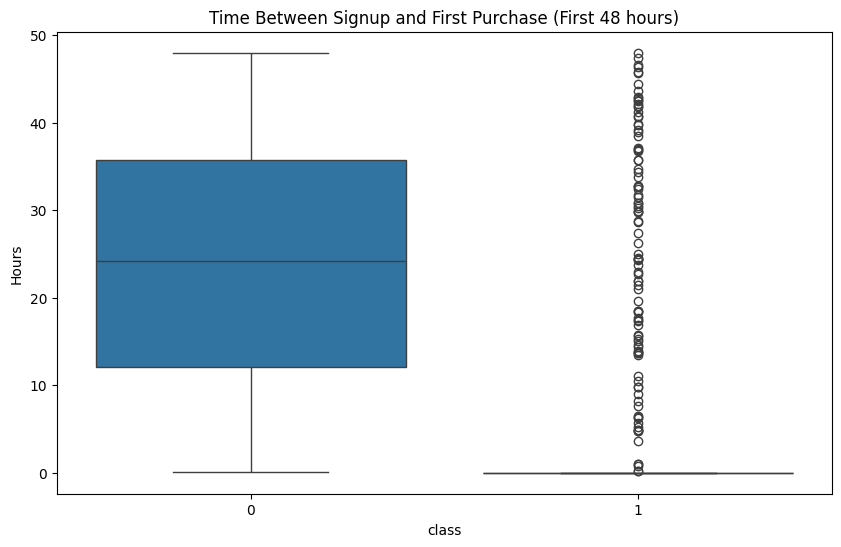

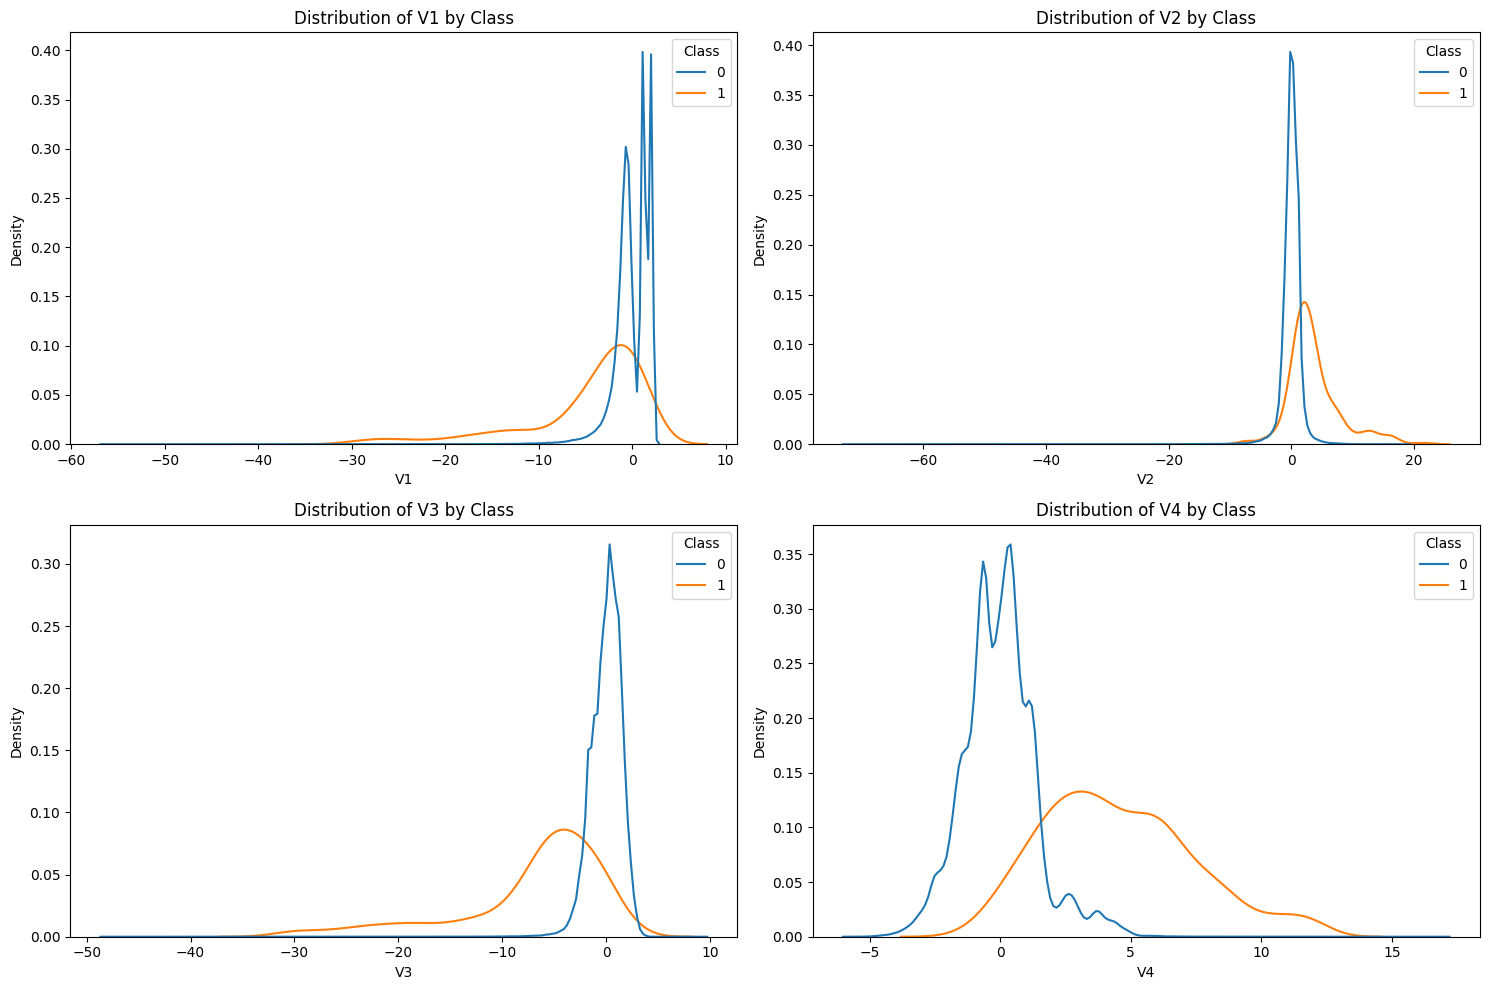

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Set style for visualizations
# plt.style.use('seaborn')
# sns.set_palette("husl")

# Load cleaned data
fraud_data = pd.read_csv('../data/Fraud_Data.csv', parse_dates=['signup_time', 'purchase_time'])
credit_data = pd.read_csv('../data/creditcard.csv.zip')

## 1. Class Distribution Analysis
def plot_class_distribution(df, target_col, title):
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=target_col, data=df)
    plt.title(f'Class Distribution - {title}', fontsize=14)
    plt.xlabel('Class (0=Legitimate, 1=Fraud)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    total = len(df)
    for p in ax.patches:
        percentage = f'{100 * p.get_height()/total:.2f}%'
        x = p.get_x() + p.get_width()/2
        y = p.get_height() + 0.02*total
        ax.annotate(percentage, (x, y), ha='center')
    
    plt.savefig(f'../reports/figures/class_distribution_{title.lower().replace(" ", "_")}.png')
    plt.show()

plot_class_distribution(fraud_data, 'class', 'E-commerce Data')
plot_class_distribution(credit_data, 'Class', 'Credit Card Data')

## 2. Transaction Value Analysis
def plot_transaction_values(df, value_col, class_col, title):
    plt.figure(figsize=(12, 6))
    
    # Log-scale for better visualization of outliers
    plt.subplot(1, 2, 1)
    sns.boxplot(x=class_col, y=value_col, data=df)
    plt.yscale('log')
    plt.title(f'Transaction Values (Log Scale) - {title}')
    
    # Zoomed-in view without outliers
    plt.subplot(1, 2, 2)
    q = df[value_col].quantile(0.99)
    sns.boxplot(x=class_col, y=value_col, data=df[df[value_col] < q])
    plt.title(f'Transaction Values (99th Percentile) - {title}')
    
    plt.tight_layout()
    plt.savefig(f'../reports/figures/transaction_values_{title.lower().replace(" ", "_")}.png')
    plt.show()

plot_transaction_values(fraud_data, 'purchase_value', 'class', 'E-commerce')
plot_transaction_values(credit_data, 'Amount', 'Class', 'Credit Card')

## 3. Temporal Patterns Analysis
def plot_temporal_patterns(df, time_col, class_col, title):
    plt.figure(figsize=(15, 10))
    
    # Hourly patterns
    plt.subplot(2, 2, 1)
    df['hour'] = df[time_col].dt.hour
    hourly = df.groupby(['hour', class_col]).size().unstack()
    hourly.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title(f'Hourly Transaction Patterns - {title}')
    
    # Daily patterns
    plt.subplot(2, 2, 2)
    df['weekday'] = df[time_col].dt.day_name()
    daily = df.groupby(['weekday', class_col]).size().unstack()
    daily.plot(kind='bar', stacked=True, ax=plt.gca())
    plt.title(f'Daily Transaction Patterns - {title}')
    
    # Fraud rate by hour
    plt.subplot(2, 2, 3)
    hourly['fraud_rate'] = hourly[1] / (hourly[0] + hourly[1])
    hourly['fraud_rate'].plot(kind='line', marker='o')
    plt.title(f'Hourly Fraud Rate - {title}')
    plt.ylabel('Fraud Rate')
    
    # Fraud rate by day
    plt.subplot(2, 2, 4)
    daily['fraud_rate'] = daily[1] / (daily[0] + daily[1])
    daily['fraud_rate'].plot(kind='line', marker='o')
    plt.title(f'Daily Fraud Rate - {title}')
    plt.ylabel('Fraud Rate')
    
    plt.tight_layout()
    plt.savefig(f'../reports/figures/temporal_patterns_{title.lower().replace(" ", "_")}.png')
    plt.show()

plot_temporal_patterns(fraud_data, 'purchase_time', 'class', 'E-commerce')

## 4. Device and Browser Analysis (E-commerce only)
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.countplot(y='browser', hue='class', data=fraud_data)
plt.title('Browser Distribution by Class')
plt.subplot(1, 2, 2)
fraud_data['device_id'].value_counts().head(20).plot(kind='bar')
plt.title('Top 20 Most Active Devices')
plt.tight_layout()
plt.savefig('../reports/figures/device_browser_analysis.png')
plt.show()

## 5. Correlation Analysis (Credit Card only)
plt.figure(figsize=(15, 12))
corr = credit_data.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Matrix - Credit Card Data')
plt.savefig('../reports/figures/correlation_matrix_credit.png')
plt.show()

## 6. Transaction Velocity Analysis (E-commerce)
# Time between signup and first purchase for fraud vs non-fraud
plt.figure(figsize=(10, 6))
fraud_data['time_since_signup'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds() / 3600
sns.boxplot(x='class', y='time_since_signup', data=fraud_data[fraud_data['time_since_signup'] < 48])  # First 48 hours
plt.title('Time Between Signup and First Purchase (First 48 hours)')
plt.ylabel('Hours')
plt.savefig('../reports/figures/signup_purchase_timing.png')
plt.show()

## 7. Country Analysis (E-commerce)
# Only if country data is available
if 'country' in fraud_data.columns:
    country_fraud = fraud_data.groupby('country')['class'].agg(['count', 'mean'])
    country_fraud = country_fraud[country_fraud['count'] > 50].sort_values('mean', ascending=False)
    
    plt.figure(figsize=(12, 8))
    plt.subplot(2, 1, 1)
    country_fraud['count'].head(20).plot(kind='bar')
    plt.title('Top 20 Countries by Transaction Volume')
    
    plt.subplot(2, 1, 2)
    country_fraud['mean'].head(20).plot(kind='bar')
    plt.title('Top 20 Countries by Fraud Rate')
    
    plt.tight_layout()
    plt.savefig('../reports/figures/country_analysis.png')
    plt.show()

## 8. PCA Feature Analysis (Credit Card only)
# Plot distributions of first few PCA components
plt.figure(figsize=(15, 10))
for i, col in enumerate(['V1', 'V2', 'V3', 'V4']):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(data=credit_data, x=col, hue='Class', common_norm=False)
    plt.title(f'Distribution of {col} by Class')
plt.tight_layout()
plt.savefig('../reports/figures/pca_feature_distributions.png')
plt.show()